# 1. Import

In [1]:
import warnings
import re
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss, average_precision_score
from sklearn.dummy import DummyClassifier
from tqdm import tqdm
from shap import TreeExplainer
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

# 2. Utils

In [3]:
def shap_sum2proba(shap_sum):
  """Compute sigmoid function of the Shap sum to get predicted probability."""
  
  return 1 / (1 + np.exp(-shap_sum))

In [4]:
def individual_log_loss(y_true, y_pred, eps = 1e-15):
  """Compute log-loss for each individual of the sample."""
  
  y_pred = np.clip(y_pred, eps, 1 - eps)
  return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

In [5]:
def get_preds_shaps(df, features, target, ix_trn):
  """Get predictions (predicted probabilities) and SHAP values for a dataset."""
    
  model = LGBMClassifier().fit(df.loc[ix_trn, features], df.loc[ix_trn, target])
  preds = pd.Series(model.predict_proba(df[features])[:,1], index=df.index)
  shap_explainer = TreeExplainer(model)
  shap_expected_value = shap_explainer.expected_value[-1]
  shaps = pd.DataFrame(
    data=shap_explainer.shap_values(df[features])[1],
    index=df.index,
    columns=features)
  return preds, shaps, shap_expected_value

In [6]:
def get_feature_contributions(y_true, y_pred, shap_values, shap_expected_value):
  """Compute prediction contribution and error contribution for each feature."""

  prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")
  
  ind_log_loss = individual_log_loss(y_true=y_true, y_pred=y_pred).rename("log_loss")
  y_pred_wo_feature = shap_values.apply(lambda feature: shap_expected_value + shap_values.sum(axis=1) - feature).applymap(shap_sum2proba)
  ind_log_loss_wo_feature = y_pred_wo_feature.apply(lambda feature: individual_log_loss(y_true=y_true, y_pred=feature))
  ind_log_loss_diff = ind_log_loss_wo_feature.apply(lambda feature: ind_log_loss - feature)
  error_contribution = ind_log_loss_diff.mean().rename("error_contribution").T
  
  return prediction_contribution, error_contribution

# 4. Toy Example

### 4.1 Generate data

In [7]:
shap_values = pd.DataFrame([
  [-2.0, 0.1, 0.8],
  [3.0,  0., 0.5],
  [-5.0, -2.0, 3.0]], columns=["job", "age", "nationality"])
y_pred = shap_values.sum(axis=1).apply(shap_sum2proba).rename("income>100k (predicted)")
y_true = pd.Series([0, 1, 0], name="income>100k (true)")

### 4.2 Compute Prediction Contribution and Error Contribution

In [8]:
prediction_contribution = shap_values.abs().mean().rename("prediction_contribution").to_frame().T

ind_log_loss = individual_log_loss(y_true=y_true, y_pred=y_pred).rename("log_loss")
y_pred_wo_feature = shap_values.apply(lambda feature: shap_values.sum(axis=1) - feature).applymap(shap_sum2proba)
ind_log_loss_wo_feature = y_pred_wo_feature.apply(lambda feature: individual_log_loss(y_true=y_true, y_pred=feature))
ind_log_loss_diff = ind_log_loss_wo_feature.apply(lambda feature: ind_log_loss - feature)
error_contribution = ind_log_loss_diff.mean().rename("error_contribution").to_frame().T

### 4.3 Display items

In [9]:
pd.concat([y_true, y_pred, ind_log_loss], axis=1)

,income>100k (true),income>100k (predicted),log_loss
0,0,0.249740,0.287335
1,1,0.970688,0.029750
2,0,0.017986,0.018150


In [10]:
pd.concat([shap_values, shap_values.sum(axis=1).rename("shap sum"), y_pred.rename("predicted probability")], axis=1)

,job,age,nationality,shap sum,predicted probability
0,-2.0,0.1,0.8,-1.1,0.249740
1,3.0,0.0,0.5,3.5,0.970688
2,-5.0,-2.0,3.0,-4.0,0.017986


In [11]:
prediction_contribution

,job,age,nationality
prediction_contribution,3.333333,0.7,1.433333


In [12]:
y_pred_wo_feature

,job,age,nationality
0,0.710950,0.231475,0.130108
1,0.622459,0.970688,0.952574
2,0.731059,0.119203,0.000911


In [13]:
ind_log_loss_wo_feature

,job,age,nationality
0,1.241154,0.263282,0.139387
1,0.474077,0.029750,0.048587
2,1.313262,0.126928,0.000911


In [14]:
ind_log_loss_diff

,job,age,nationality
0,-0.953819,0.024053,0.147949
1,-0.444327,0.000000,-0.018837
2,-1.295112,-0.108778,0.017238


In [15]:
error_contribution

,job,age,nationality
error_contribution,-0.897752,-0.028242,0.048783


# 3. Theory

$$
\frac{1}{N} \sum_{i=1}^{N} - y_i \cdot \log ( p_i ) - ( 1 - y_i ) \cdot \log ( 1 - p_i ) 
$$

$$
- y \cdot \log(p) - ( 1 - y ) \cdot \log ( 1 - p ) 
$$

$$
\begin{cases}
-\log(p) & \text{if $y$ = 1}\\
-\log(1-p) & \text{if $y$ = 0}\\
\end{cases} 
$$

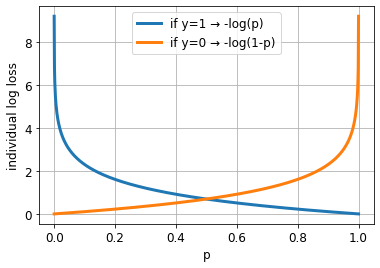

In [16]:
fig, ax = plt.subplots()

p = np.linspace(.0001, .9999, 1000)

ax.plot(p, -np.log(p), lw=3, label = "if y=1 → -log(p)")
ax.plot(p, -np.log(1-p), lw=3, label = "if y=0 → -log(1-p)")
ax.set_xlabel("p", fontsize=12)
ax.set_ylabel("individual log loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid()
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("logloss_curves_.png", dpi=200, bbox_inches="tight")

$$
p=\frac{1}{1 + e^{\,-\,\mathrm{shap\,sum}}}
$$

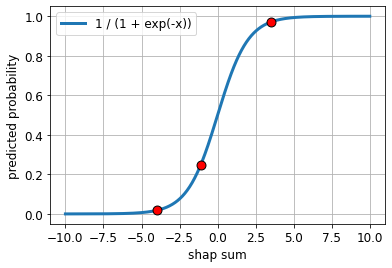

In [17]:
fig, ax = plt.subplots()

shap_sum = np.linspace(-10, 10, 1000)

ax.plot(shap_sum, shap_sum2proba(shap_sum), lw=3, label = "1 / (1 + exp(-x))")

for i in range(3):
  ax.scatter(shap_values.sum(axis=1).loc[i], y_pred.loc[i], color="red", edgecolors="black", s=80, zorder=100)

ax.set_xlabel("shap sum", fontsize=12)
ax.set_ylabel("predicted probability", fontsize=12)
ax.legend(fontsize=12)
ax.grid()
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("sigmoid_func_.png", dpi=200, bbox_inches="tight")

# 5. Real dataset

In [18]:
#df = get_data("gold", verbose=False)
#df *= 100
#df["Gold_T+22"] = (df["Gold_T+22"] > 5).astype(int)

In [22]:
df = pd.read_csv("gold.csv", sep="\t")

target = "Gold_T+22"

features = [f for f in df.columns if f != target]
argsort = np.argsort([f.split("T-")[0] + "T-" + "{:2.1f}".format(float(f.split("T-")[1])).zfill(4) for f in features])
features = [features[arg] for arg in argsort]

# 6. Data Analysis

In [23]:
df[target].describe()

count    2558.000000
mean        0.145035
std         0.352205
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Gold_T+22, dtype: float64

In [24]:
pd.set_option('display.max_columns', 8)
pd.set_option("display.max_rows", 5)

df[features + [target]].round(2)

,3M Libor_T-1,3M Libor_T-7,3M Libor_T-14,3M Libor_T-22,...,Yuan_T-7,Yuan_T-14,Yuan_T-22,Gold_T+22
0,0.00,-1.80,-2.90,-4.07,...,-0.01,-0.02,-0.00,0
1,-0.46,-1.47,-3.34,-4.51,...,-0.01,-0.04,-0.01,0
...,...,...,...,...,...,...,...,...,...
2556,-0.23,0.02,-1.18,-6.73,...,1.25,1.88,3.98,0
2557,-0.29,-0.83,-1.93,-5.03,...,1.21,2.22,3.46,0


In [25]:
for enum, f in enumerate(sorted(set([f.split("_")[0] for f in features]))):
  print(f.ljust(20), end="")
  if enum % 4 == 3:
    print("\n", end="")

3M Libor            AUD                 Brent 1             Brent 2             
Corn                Crude Palm Oil      DJ Index            Dollex              
EM Bond             EMEquity ETF        Euro Curr           Gold                
INR                 Light Crude         MR                  MSCI APAC ex J      
MSCI EM             Nifty               Nikkei Ind          Palladium           
Platinum            S&P 500             Shanghai Index      Silver              
US Bond ETF         Wheat 1             Wheat 2             White Sugar         
Yuan                

# 7. Train/Validation/Test Split

In [26]:
np.random.seed(123)
fold = np.random.choice(["trn", "val", "tst"], p=[1/3, 1/3, 1/3], size=len(df))

ix_trn = fold == "trn"
ix_val = fold == "val"
ix_tst = fold == "tst"

In [27]:
assert (ix_trn.astype(int) + ix_val.astype(int) + ix_tst.astype(int) == 1).all()

# 8. Single Model

### 8.1 Compute Predictions and Shap Values

In [45]:
preds, shaps, shap_expected_value = get_preds_shaps(df=df, features=features, target=target, ix_trn=ix_trn)

assert ((preds - (shap_expected_value + shaps.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()

prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
  y_true=df.loc[ix_trn, target], 
  y_pred=preds.loc[ix_trn], 
  shap_values=shaps.loc[ix_trn, :],
  shap_expected_value=shap_expected_value
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
  y_true=df.loc[ix_val, target], 
  y_pred=preds.loc[ix_val], 
  shap_values=shaps.loc[ix_val, :],
  shap_expected_value=shap_expected_value
)

contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

### 8.2 Write/Read Results

In [46]:
contributions_trn.to_csv("contributions_trn.csv", index=True)
contributions_val.to_csv("contributions_val.csv", index=True)

In [47]:
contributions_trn = pd.read_csv("contributions_trn.csv", index_col=0)
contributions_val = pd.read_csv("contributions_val.csv", index_col=0)

### 8.3 Prediction vs. Error Contribution (Training)

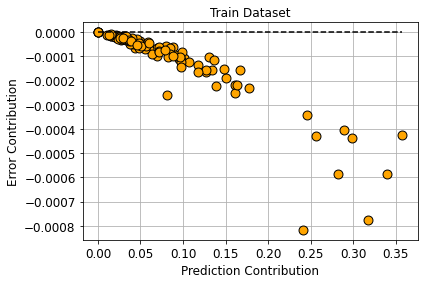

In [48]:
fig, ax = plt.subplots()

ax.scatter(contributions_trn["prediction_contribution"], contributions_trn["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_trn["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid(); ax.set_axisbelow(True)
ax.set_title("Train Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_trn.png", dpi=200, bbox_inches="tight")

In [49]:
pd.set_option("display.max_rows", 10)

contributions_trn.sort_values("prediction_contribution", ascending=False).head(10)

,prediction_contribution,error_contribution
US Bond ETF_T-22,0.357729,-0.000426
INR_T-22,0.340033,-0.000584
3M Libor_T-22,0.317645,-0.000776
EMEquity ETF_T-14,0.299084,-0.000438
Crude Palm Oil_T-22,0.289143,-0.000404
3M Libor_T-14,0.282654,-0.000586
White Sugar_T-14,0.256399,-0.000428
Crude Palm Oil_T-14,0.245532,-0.000340
Nikkei Ind_T-22,0.241579,-0.000817
Corn_T-1,0.177843,-0.000232


### 8.4 Prediction vs. Error Contribution (Validation)

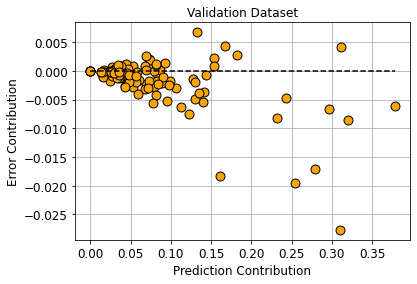

In [50]:
fig, ax = plt.subplots()

ax.scatter(contributions_val["prediction_contribution"], contributions_val["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_val["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)

ax.grid()
ax.set_axisbelow(True)
ax.set_title("Validation Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_val.png", dpi=200, bbox_inches="tight")

In [51]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=True).round(4).head(10)

,prediction_contribution,error_contribution
3M Libor_T-22,0.3106,-0.0277
Nikkei Ind_T-22,0.2540,-0.0196
Corn_T-22,0.1617,-0.0184
Crude Palm Oil_T-22,0.2796,-0.0170
INR_T-22,0.3197,-0.0086
Crude Palm Oil_T-14,0.2321,-0.0082
Gold_T-22,0.1231,-0.0075
3M Libor_T-14,0.2961,-0.0067
Yuan_T-22,0.1133,-0.0062
US Bond ETF_T-22,0.3782,-0.0061


In [52]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=False).round(4).head(10)

,prediction_contribution,error_contribution
Palladium_T-14,0.1320,0.0067
Corn_T-1,0.1678,0.0044
EMEquity ETF_T-14,0.3114,0.0041
Nikkei Ind_T-1,0.1821,0.0027
US Bond ETF_T-1,0.0689,0.0025
INR_T-1,0.1539,0.0022
Crude Palm Oil_T-1,0.0723,0.0021
EMEquity ETF_T-7,0.0741,0.0019
Palladium_T-1,0.0931,0.0014
US Bond ETF_T-14,0.0813,0.0011


# 9. Recursive Feature Elimination (RFE)

### 9.1. RFE - Error Contribution
At each step, we remove the feature with the highest error contribution.

In [ ]:
rfe_error = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
  
  preds, shaps, shap_expected_value = get_preds_shaps(df=df, features=features_curr, target=target, ix_trn=ix_trn)
  prediction_contribution, error_contribution = get_feature_contributions(
    y_true=df.loc[ix_val, target], 
    y_pred=preds.loc[ix_val], 
    shap_values=shaps.loc[ix_val, :],
    shap_expected_value=shap_expected_value
  )

  rfe_error.loc[iteration, "feature_drop"] = feature_drop
  rfe_error.loc[iteration, "n_features"] = len(features_curr)
  rfe_error.loc[iteration, "contrib"] = error_contribution.max()
  rfe_error.loc[iteration, "logloss_trn"] = log_loss(df.loc[ix_trn, target], preds.loc[ix_trn])
  rfe_error.loc[iteration, "logloss_val"] = log_loss(df.loc[ix_val, target], preds.loc[ix_val])
  rfe_error.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])
  rfe_error.loc[iteration, "ap_trn"] = average_precision_score(df.loc[ix_trn, target], preds.loc[ix_trn])
  rfe_error.loc[iteration, "ap_val"] = average_precision_score(df.loc[ix_val, target], preds.loc[ix_val])
  rfe_error.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])
  
  feature_drop = error_contribution.idxmax()
  features_curr.remove(feature_drop)

### 9.2. RFE - Prediction Contribution
At each step, we remove the feature with the smallest prediction contribution (i.e. the less important feature)

In [ ]:
rfe_prediction = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
  
  preds, shaps, shap_expected_value = get_preds_shaps(df=df, features=features_curr, target=target, ix_trn=ix_trn)
  prediction_contribution, error_contribution = get_feature_contributions(
    y_true=df.loc[ix_val, target], 
    y_pred=preds.loc[ix_val], 
    shap_values=shaps.loc[ix_val, :],
    shap_expected_value=shap_expected_value
  )

  rfe_prediction.loc[iteration, "feature_drop"] = feature_drop
  rfe_prediction.loc[iteration, "n_features"] = len(features_curr)
  rfe_prediction.loc[iteration, "contrib"] = prediction_contribution.min()
  rfe_prediction.loc[iteration, "logloss_trn"] = log_loss(df.loc[ix_trn, target], preds.loc[ix_trn])
  rfe_prediction.loc[iteration, "logloss_val"] = log_loss(df.loc[ix_val, target], preds.loc[ix_val])
  rfe_prediction.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])
  rfe_prediction.loc[iteration, "ap_trn"] = average_precision_score(df.loc[ix_trn, target], preds.loc[ix_trn])
  rfe_prediction.loc[iteration, "ap_val"] = average_precision_score(df.loc[ix_val, target], preds.loc[ix_val])
  rfe_prediction.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])
  
  feature_drop = prediction_contribution.idxmin()
  features_curr.remove(feature_drop)

### 9.3 Write Results

In [53]:
rfe_error.to_csv("gold_rfe_error.csv", index=False)
rfe_prediction.to_csv("gold_rfe_prediction.csv", index=False)

### 9.4 Read Results

In [28]:
rfe_error = pd.read_csv("gold_rfe_error.csv")
rfe_prediction = pd.read_csv("gold_rfe_prediction.csv")

### 9.5 Plot RFE on Validation (Logloss)

In [29]:
max_iter_show = len(features) - 9

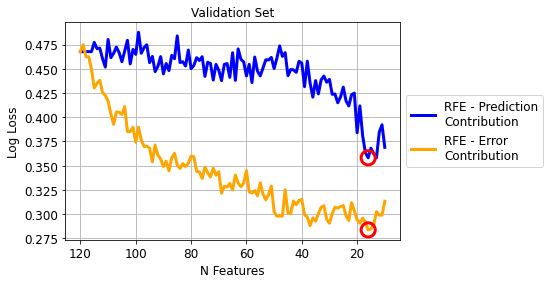

In [56]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["logloss_val"].idxmin()
idxmin_error = rfe_error["logloss_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["logloss_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["logloss_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction,"n_features"], rfe_prediction.loc[idxmin_prediction,"logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error,"n_features"], rfe_error.loc[idxmin_error,"logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_logloss_val_.png", dpi=200, bbox_inches="tight")

In [57]:
rfe_error.sort_values("logloss_val", ascending=True).head(1)

,feature_drop,n_features,contrib,logloss_trn,...,logloss_tst,ap_trn,ap_val,ap_tst
104,Nifty_T-7,16.0,-0.00313,0.003295,...,0.274596,1.0,0.74032,0.700379


In [58]:
rfe_prediction.sort_values("logloss_val", ascending=True).head(1)

,feature_drop,n_features,contrib,logloss_trn,...,logloss_tst,ap_trn,ap_val,ap_tst
104,S&P 500_T-14,16.0,0.304652,0.003227,...,0.332467,1.0,0.662959,0.63836


### 9.6 Plot RFE on Test (Logloss)

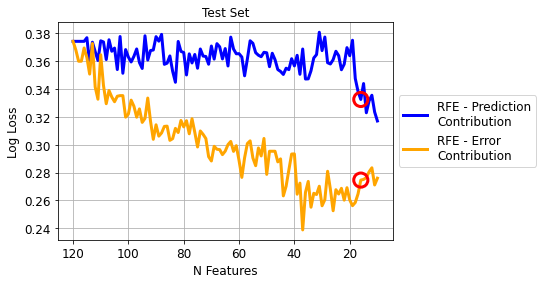

In [59]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["logloss_val"].idxmin()
idxmin_error = rfe_error["logloss_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["logloss_tst"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["logloss_tst"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction,"n_features"], rfe_prediction.loc[idxmin_prediction,"logloss_tst"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error,"n_features"], rfe_error.loc[idxmin_error,"logloss_tst"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Test Set", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_logloss_tst_.png", dpi=200, bbox_inches="tight")

### 9.7 Plot RFE on Validation (Average Precision)

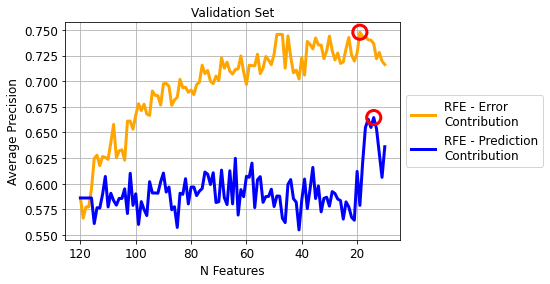

In [35]:
fig, ax = plt.subplots()

idxmax_prediction = rfe_prediction["ap_val"].idxmax()
idxmax_error = rfe_error["ap_val"].idxmax()

ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["ap_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["ap_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.scatter(-rfe_prediction.loc[idxmax_prediction,"n_features"], rfe_prediction.loc[idxmax_prediction,"ap_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmax_error,"n_features"], rfe_error.loc[idxmax_error,"ap_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Average Precision", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_ap_val_.png", dpi=200, bbox_inches="tight")

In [31]:
rfe_error.sort_values("ap_val", ascending=False).head(1)

,feature_drop,n_features,contrib,logloss_trn,...,logloss_tst,ap_trn,ap_val,ap_tst
101,INR_T-14,19.0,-0.000959,0.002888,...,0.256222,1.0,0.747679,0.72811


In [32]:
rfe_prediction.sort_values("ap_val", ascending=False).head(1)

,feature_drop,n_features,contrib,logloss_trn,...,logloss_tst,ap_trn,ap_val,ap_tst
106,INR_T-14,14.0,0.366041,0.003611,...,0.322916,1.0,0.664506,0.655899


### 9.8 Plot RFE on Test (Average Precision)

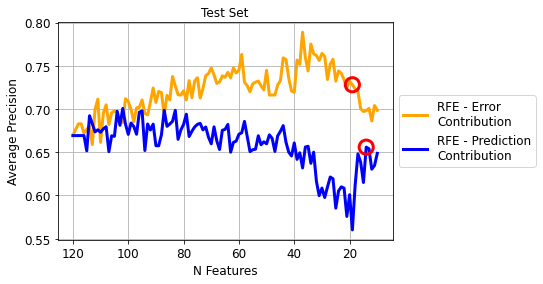

In [34]:
fig, ax = plt.subplots()

idxmax_prediction = rfe_prediction["ap_val"].idxmax()
idxmax_error = rfe_error["ap_val"].idxmax()

ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["ap_tst"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["ap_tst"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.scatter(-rfe_prediction.loc[idxmax_prediction,"n_features"], rfe_prediction.loc[idxmax_prediction,"ap_tst"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmax_error,"n_features"], rfe_error.loc[idxmax_error,"ap_tst"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Test Set", fontsize=12)
ax.set_ylabel("Average Precision", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_ap_tst_.png", dpi=200, bbox_inches="tight")